In [1]:
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from astropy.wcs import WCS
from ClusterModel import model
from ClusterModel import model_modpar
from ClusterModel import model_tools

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
clust = model.Cluster(name='Coma', 
                      redshift=0.023, M500=7e14*u.Msun, 
                      cosmology=cosmo, silent=False, 
                      output_dir='/home/astrogamma/Project/Output/TestClusterModel')

                 __  __ ___ ___   _   ___   ___                 
                |  \/  |_ _/ __| /_\ |   \ / _ \                
                | |\/| || | (__ / _ \| |) | (_) |               
                |_|  |_|___\___/_/ \_\___/ \___/                
 Modeling the Intra Cluster Atmosphere for Diverse Observations 
----------------------------------------------------------------
                                                                
Setting gNFW Planck coll. (2013) UPP.


In [3]:
#----- Some parameters that can be set at when defining the cluster
clust.coord = SkyCoord("194.953d  27.9806d", frame="icrs", unit="deg")

#----- Define the relevant ICM model (available models are defined in model_modpar.py)

# Density profile of the target thermal gas
clust.density_gas_model = {'name':'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}

# Pressure profile of the target thermal gas
clust.pressure_gas_model = {'name':'GNFW', 'P_0':2.2e-2*u.keV/u.cm**3, 'c500':2.9, 'a':1.8, 'b':3.1, 'c':0.0}

# Set the cosmic ray density profile to the same shape as the thermal gas density
clust.set_density_crp_isodens_scal_param()

# Cosmic ray proton spectrum
clust.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.3}

# Cosmic ray proton normalization
clust.X_cr_E = {'X':0.01, 'R_norm':clust.R500} # X is the CRp/thermal energy ratio, normalized within R_norm


#Set some random stolen models for the primary electrons
clust.spectrum_cre1_model = {'name':  'PowerLaw', 'Index':2.3}
                             #'ExponentialCutoffPowerLaw','Index':3.3, 'CutoffEnergy':1e7*u.keV}
                           
                        
## You can try building a model incorporating the energy losses from sync and IC!


## For density you can just make the same as protons --> set it equal to the thermal gas 
clust.density_cre1_model = {'name': 'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}

#pull out some random min and max energies
Eemin = clust.Epmin 
Eemax = clust.Epmax

Setting coord value
Setting density_gas_model value
Fixing: R500
Setting pressure_gas_model value
Fixing: R500
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting the minimal proton energy
Getting the maximal proton energy


In [4]:
## Just use the avalialble generic functions

clust.density_cre1_model['n_0'] = 1.0 *u.adu

def get_normed_density_cre1_profile(cl = clust, rad = np.logspace(0,4,100)*u.kpc):
    
   # rad = model_tools.check_qarray(rad, unit = 'kpc')
    nr = cl._get_generic_profile(rad, cl.density_cre1_model)
    nr[rad > cl._R_truncation] *= 0 
    
    return rad, nr.to('adu')


def get_normed_spectrum_cre1(cl , en): 
    
    se = cl._get_generic_spectrum(en, cl.spectrum_cre1_model)
    se[en >Eemax] *= 0
    se[en <Eemin] *= 0
    
    return en, se*u.adu

In [5]:
A = 1/u.GeV/u.cm**3

def cre1_2d(cl = clust, en= np.logspace(-2,7,100)*u.GeV, rd =np.logspace(0,4,100)*u.kpc):
    
    #norm
    #r = norm_electrons(clust)
    #norm_electrons(cl)
    #spatial
    rad, fd = get_normed_density_cre1_profile(cl, rd)
    fd2 = model_tools.replicate_array(fd.to_value('adu'), len(en), T = False )
    #energy
    eng, fe = get_normed_spectrum_cre1(cl, en)
    fe2 = model_tools.replicate_array(fe.to_value('adu'), len(rd), T = True )
    
    spectrum= A*fd2*fe2
     
    return spectrum.to('GeV-1 cm-3')


# 1) No Radius
I tried to use a function with only energy dependence for Je, but it did not work

In [138]:
## Here I try and fail -- No radius dependence
## 

from ClusterModel.ClusterTools import cluster_electron_emission as emi

def rate_sync_norad(energy = np.logspace(-9,-2,100)*u.eV ):
   



    energy = model_tools.check_qarray(energy, unit='eV')
    #Define Je: 
    def Je2(  eng): return get_normed_spectrum_cre1(clust , eng*u.GeV)
    

    
    
    #Use the class
    model =  emi.ClusterElectronEmission (Je = Je2,Eemin=(const.m_e*const.c**2).to('GeV'), Eemax = clust.Epmax, NptEePd=clust._Npt_per_decade_integ)
    rate = model.synchrotron( energy).T
    
    return rate.to('GeV-1 s-1')


In [139]:
trial = rate_sync_norad()

Getting the maximal proton energy


TypeError: can't multiply sequence by non-int of type 'float'

### I try the part that gives an error:
The error disappears when I change norm into an integer

In [173]:
Eemino = (const.m_e *const.c**2).to_value('GeV')
       
Eemaxo = clust.Epmax
Eemaxo = Eemax.to_value('GeV')
NptEePd=clust._Npt_per_decade_integ

Eeo = np.logspace(np.log10(Eemino), np.log10(Eemaxo), int(NptEePd*(np.log10(Eemaxo/Eemino))))

Jee = get_normed_spectrum_cre1(clust , Eeo*u.GeV)
out = 1.0 * Jee * u.GeV**-1  # 1D

Getting the maximal proton energy


TypeError: can't multiply sequence by non-int of type 'float'

# 2) Rewrite the Whole Function; No Radius
- B field is constant
- Photon energy input has to have same length as electron energy, otherwise doesnt work

In [215]:
#rate sync
from scipy.special import cbrt


def Gtilde( x):
        """
        Useful equation. Aharonian, Kelner, Prosekin 2010 Eq. D7
        Taken from Naima.
        
        Factor ~2 performance gain in using cbrt(x)**n vs x**(n/3.)
        Invoking crbt only once reduced time by ~40%
        """
        cb = cbrt(x) # x**1/3
        gt1 = 1.808 * cb / np.sqrt(1 + 3.4 * cb ** 2.0)
        gt2 = 1 + 2.210 * cb ** 2.0 + 0.347 * cb ** 4.0
        gt3 = 1 + 1.353 * cb ** 2.0 + 0.217 * cb ** 4.0
        
        return gt1 * (gt2 / gt3) * np.exp(-x)
    
    
    

#radius = np.logspace(0,4,100)*u.kpc
    
#Constant B Field

B=1.0*u.uG

#rate = synchrotron( energy, radius, B).T
    
    

    
 #   def synchrotron( Ephoton_input, radius, B=1.0*u.uG):
        
NptEePd = clust._Npt_per_decade_integ
        #Electron energy
Eemino = (const.m_e *const.c**2).to_value('GeV')
Eemaxo = clust.Epmax
Eemaxo = Eemaxo.to_value('GeV')
Eeo = np.logspace(np.log10(Eemino), np.log10(Eemaxo), int(NptEePd*(np.log10(Eemaxo/Eemino))))

        # Check input photons
    
    
energy = np.logspace(-9,-2,len(Eeo))*u.eV

Ephoton = energy.to('eV')
if type(Ephoton) == float: Ephoton = np.array([Ephoton])
#Eemin = clust.Epmin 
#Eemax = clust.Epmax
      
    
    
gamma = (Eeo/(const.m_e*const.c**2).to_value('GeV')) # 1D
ampli = np.sqrt(3)/(8*np.pi**2)*(const.e.value*const.e.unit)**3/(const.eps0*const.m_e*const.c*const.hbar)

        #---------- Case of integrated quantities, no radius
        # Get the electron distribution
Je = get_normed_spectrum_cre1(clust , Eeo*u.GeV)
Je = Je*u.GeV**-1
#to_value('GeV-1')

#cre1_2d( clust, Eeo*u.GeV, np.logspace(0,4,len(Eeo))*u.kpc).to_value('GeV-1 cm-3').T*u.GeV**-1
        #Je = Je*u.GeV**-1

        # Get the normalization function (1D: Ephot)
func = ampli * B / Ephoton
        
        # Get the critical energy and energy ratio
Ec = (3.0/2)*gamma**2*const.e.value*const.e.unit*B*const.hbar / (const.m_e) # 1D: Eelec
EphotEc = Ephoton.to_value('GeV') / np.vstack(Ec.to_value('GeV')) # 2D: photon energy, electron energy

        # Compute integrand
dNphot_dEdt = func * Gtilde(EphotEc)
        
        # Integrate over electron energy
dNphot_dEdt = model_tools.trapz_loglog(np.vstack(Je.value)*Je.unit * dNphot_dEdt, Eeo*u.GeV, axis=0)

        # Get the output
output = dNphot_dEdt.to('GeV-1 s-1')

output
    

Getting the maximal proton energy


UnitConversionError: 'GeV' (energy) and '1 / GeV' are not convertible

In [207]:
Je =list(Je)
type(Je)

list

### Try getting Je Separately

In [181]:
NptEePd = clust._Npt_per_decade_integ
        #Electron energy
        
        #Electron energy
Eeminu = (const.m_e *const.c**2).to_value('GeV')
Eemaxu = clust.Epmax
Eemaxu = Eemaxu.to_value('GeV')
Eeu = np.logspace(np.log10(Eeminu), np.log10(Eemaxu),    int(NptEePd*(np.log10(Eemaxu/Eeminu))))
A = 1/u.GeV/u.cm**3
radius = np.logspace(0,4,100)*u.kpc 
lolz = cre1_2d(  clust , Eeu*u.GeV, radius).to_value('GeV-1 cm-3').T*u.GeV**-1
lolz

Getting the maximal proton energy


<Quantity [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            1.13292437e-16, 9.48632235e-17, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            1.13292162e-16, 9.48629929e-17, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            1.13291830e-16, 9.48627150e-17, 0.00000000e+00],
           ...,
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00]] 1 / GeV>

# 3) Parameterize Norm Externally for the Fit
- First just try to see if it makes sense

In [144]:
### Basic Synchrotron Rate Function 


from ClusterModel.ClusterTools import cluster_electron_emission as emi


def rate_sync(energy = np.logspace(-9,-2,100)*u.eV, radius = np.logspace(0,4,100)*u.kpc ):
    
    #Get Magnetic field
    radius, B = clust.get_magfield_profile(radius)
    
    #Define Je: 
    def Je2(rad, eng): return cre1_2d(clust, eng*u.GeV, rad*u.kpc).to_value('GeV-1 cm-3').T


    #rad*u.kpc
    
    
    #Use the class
    model =  emi.ClusterElectronEmission (Je = Je2,Eemin=(const.m_e*const.c**2).to('GeV'), NptEePd=clust._Npt_per_decade_integ)
    rate = model.synchrotron( energy, radius_input = radius, B=B).T
    
    return rate.to('GeV-1 cm-3 s-1')

## Multiply the result by a custom Norm

In [146]:
default = clust.get_rate_synchrotron()
dN_dEdVdt = rate_sync()

## Mock Norm multiplies it externally 
B = 0.0001
tryme = B*rate_sync()

Text(0.5,1,'Rate for Primary Electrons')

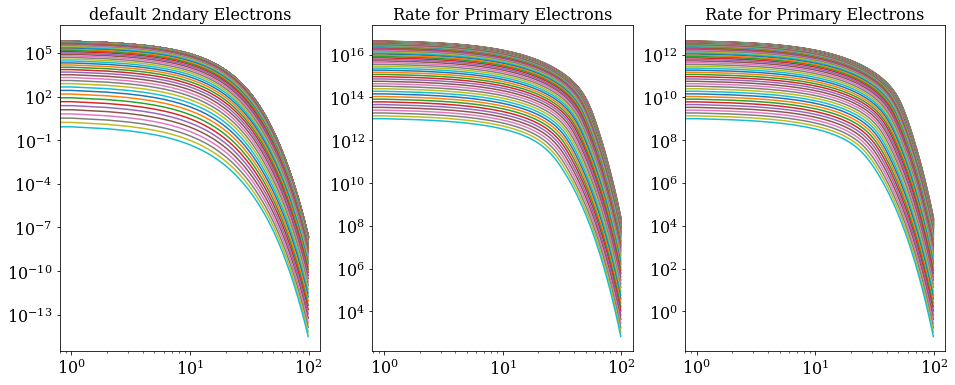

In [147]:
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.loglog(default)
plt.title("default 2ndary Electrons")

plt.subplot(132)
plt.loglog(dN_dEdVdt)
plt.title("Rate for Primary Electrons")


plt.subplot(133)
plt.loglog(tryme)
plt.title("Rate for Primary Electrons")


In [49]:
# aa = 1/u.GeV/u.cm**3
# int(aa.value)

1

In [148]:
# #Get energy
# freq = np.logspace(-3,2,100)*u.GHz        
# norm = 1
# energy = (const.h*freq).to('eV')
    
# Rmin = clust._Rmin
    
# Rmax = clust._R500
        
# freq = np.logspace(-3,2,100)*u.GHz        
# #sample radius
# rad = model_tools.sampling_array(Rmin, Rmax, NptPd = clust._Npt_per_decade_integ, unit = True)
#     #Use rate sync to get synchotron rate
# dNdEdVdt = rate_sync(energy, rad)
#     #integrate spherically
# dNdEdt = model_tools.spherical_integration(norm * dNdEdVdt, rad)
    
#     #This gave us luminosity; now get flux 
# dNdEdSdt = dNdEdt / (4*np.pi * clust._D_lum**2)
    

## Try spectrum 


also add another one that uses secondary population

In [193]:
def sync_spectrum( freq = np.logspace(-3,2,100)*u.GHz, norm = 1):
    
    '''Uses Primary Electron population via rate_sync() and multiplies the result by the norm
    '''
    
    #Get energy
    #freq = model_tools.check_qarray(freq, unit='GHz')
    energy = (const.h*freq).to('eV')
    
 
    Rmin = clust._Rmin
    
    Rmax = clust._R500
        
        
    #sample radius
    rad = model_tools.sampling_array(Rmin, Rmax, NptPd = clust._Npt_per_decade_integ, unit = True)
    #Use rate sync to get synchotron rate
   
    dNdEdVdt = rate_sync(energy, rad)
    #integrate spherically
    dNdEdt = model_tools.spherical_integration(norm * dNdEdVdt, rad)
    
    #This gave us luminosity; now get flux 
    dNdEdSdt = dNdEdt / (4*np.pi * clust._D_lum**2)
    
    #Convert to Jy 
    return freq, (dNdEdSdt*energy**2 / freq).to('Jy')


def sync_spectrum2( freq = np.logspace(-3,2,100)*u.GHz, norm = 1):
    
    '''This one uses the Secondary Electron population
    '''
    
    #Get energy
    #freq = model_tools.check_qarray(freq, unit='GHz')
    energy = (const.h*freq).to('eV')
    
 
    Rmin = clust._Rmin
    
    Rmax = clust._R500
        
        
    #sample radius
    rad = model_tools.sampling_array(Rmin, Rmax, NptPd = clust._Npt_per_decade_integ, unit = True)
    #Use rate sync to get synchotron rate
   
    dNdEdVdt = clust.get_rate_synchrotron(energy, rad)
    #integrate spherically
    dNdEdt = model_tools.spherical_integration(norm * dNdEdVdt, rad)
    
    #This gave us luminosity; now get flux 
    dNdEdSdt = dNdEdt / (4*np.pi * clust._D_lum**2)
    
    #Convert to Jy 
    return freq, (dNdEdSdt*energy**2 / freq).to('Jy')

### Sanity Check 
Plot along with the automatic one

Text(0.5,1,'new')

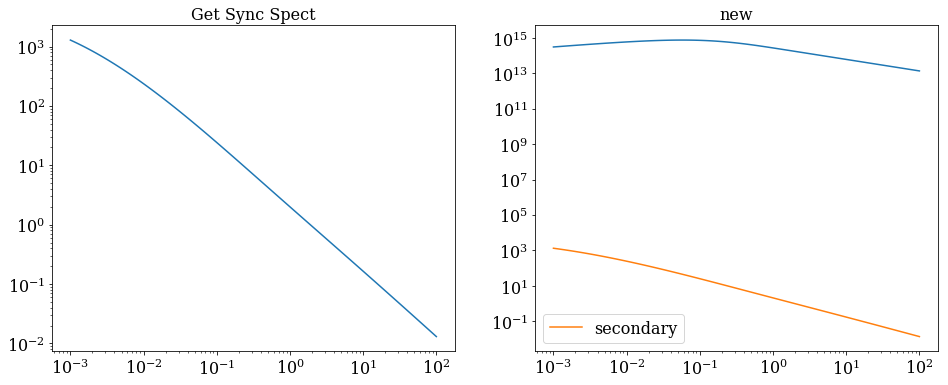

In [196]:
plt.figure(figsize = (15,6))
plt.subplot(121)
### Automatic function
frequency, readyspectrum = clust.get_synchrotron_spectrum()
plt.loglog(frequency,readyspectrum)
plt.title("Get Sync Spect")

#New one 
plt.subplot(122)
frequency, spectrum = sync_spectrum()
frequency, spectrum2 = sync_spectrum2()
plt.loglog(frequency, spectrum)
plt.loglog(frequency, spectrum2, label = "secondary")
plt.legend()

plt.title("new")


## Coma

In [87]:
# Radio total flux [Thierbach et al (2003)]:

dat_freq = np.array([30.9,43,73.8,151,326,408,430,608.5,1380,1400,2675,2700,4850])*u.MHz
dat_flux = np.array([49,51,17,7.2,3.81,2.0,2.55,1.2,0.53,0.64,0.11,0.07,0.03])*u.Jy
dat_err  = np.array([10,13,12,0.8,0.03,0.2,0.28,0.3,0.05,0.035,0.03,0.02,0.01])*u.Jy

## Use Different Norms using dat freq

In [199]:

## Different Norms : 0.001 and 0.1
freq2, spectrum1 = sync_spectrum(dat_freq, 1e-13)
freq2, spectrum2 = sync_spectrum(dat_freq, 1e-10)


## Plot for Primary and Secondary Electron Populations
- With primary, try different normalizations

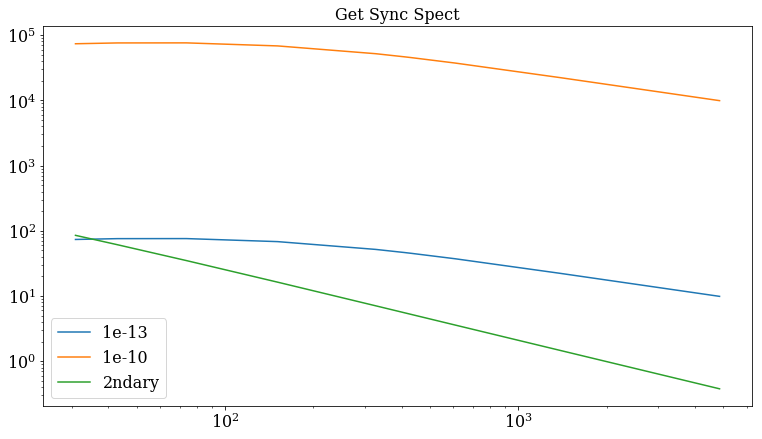

In [200]:
plt.figure(figsize = (12,7))
### Automatic function
plt.loglog(dat_freq,spectrum1, label = "1e-13")
plt.title("Get Sync Spect")

#New one 
plt.loglog(dat_freq, spectrum2, label = "1e-10")
frequency, readyspectrum = clust.get_synchrotron_spectrum(dat_freq)
frequency, spectrum2nd = sync_spectrum2(dat_freq)
plt.loglog(frequency,spectrum2nd, label = "2ndary")
plt.legend()

## With Data and Simple Power Law

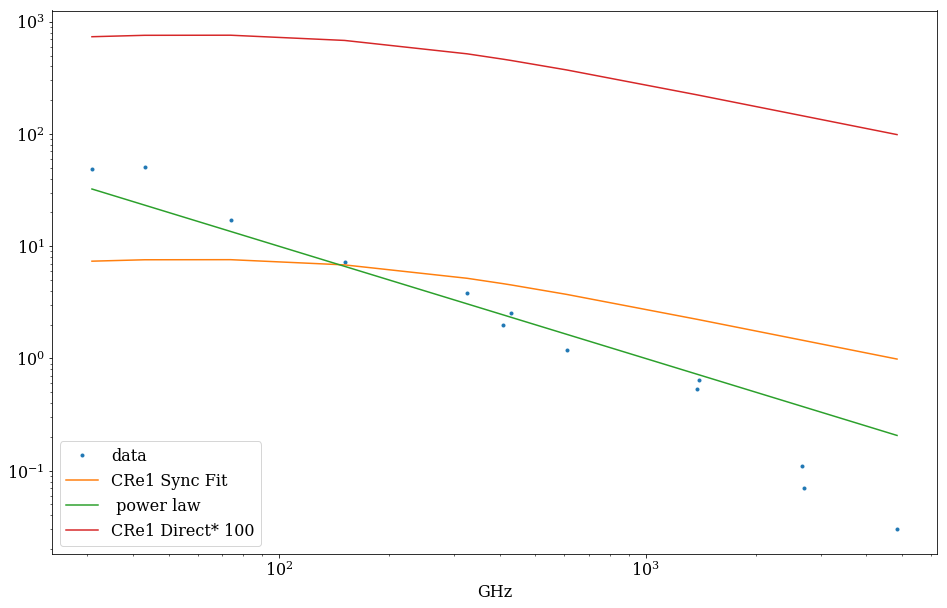

In [167]:


#Primary Electron Population, custom Norm 
dat_freq, spectrum = sync_spectrum(dat_freq, 1e-14)

## SyncFit , norm set 
def syncfit(x):
    return sync_spectrum(x,1e-14)[1]

## Regular Power Law
def fitfunc(x):
    return 10**3*(x)**(-1)

trial = fitfunc(dat_freq)
trial2 = syncfit(dat_freq)

plt.figure(figsize=(15,10))

##DATA
plt.loglog(dat_freq,dat_flux,".", label = "data")
#PRIMARY Sync Fit
plt.loglog(dat_freq, trial2, "-", label = "CRe1 Sync Fit ")
#Regular Power Law
plt.loglog(dat_freq, trial,label =  " power law")
#Primary, direct
plt.loglog(dat_freq, 100*spectrum , label = "CRe1 Direct* 100")


plt.xlabel(frequency.unit)
plt.legend()
plt.show()

In [162]:
def syncfit(x,a):
    return sync_spectrum(x,a)[1]

syncfit(dat_freq, 1)

<Quantity [7.36139834e+14, 7.57738638e+14, 7.59264790e+14, 6.82112928e+14,
           5.18219669e+14, 4.64521298e+14, 4.52037427e+14, 3.72569618e+14,
           2.23467047e+14, 2.21400443e+14, 1.45457059e+14, 1.44580302e+14,
           9.88023368e+13] Jy>

### Fit Power Law as Before
Verifying that it works

In [169]:
from scipy import optimize


## Sync Spectrum will be identicql to the one from "electrons", but with norm as a parameter
def syncfit(x,a):
    sync_spectrum(a,x)

def fitfunc(x, a, b):
    return a*(x)**b

params, params_covariance = optimize.curve_fit(fitfunc, dat_freq, dat_flux,
                                               p0=[2, 2])

print(params)

[ 2.27834835e+03 -1.08423216e+00]


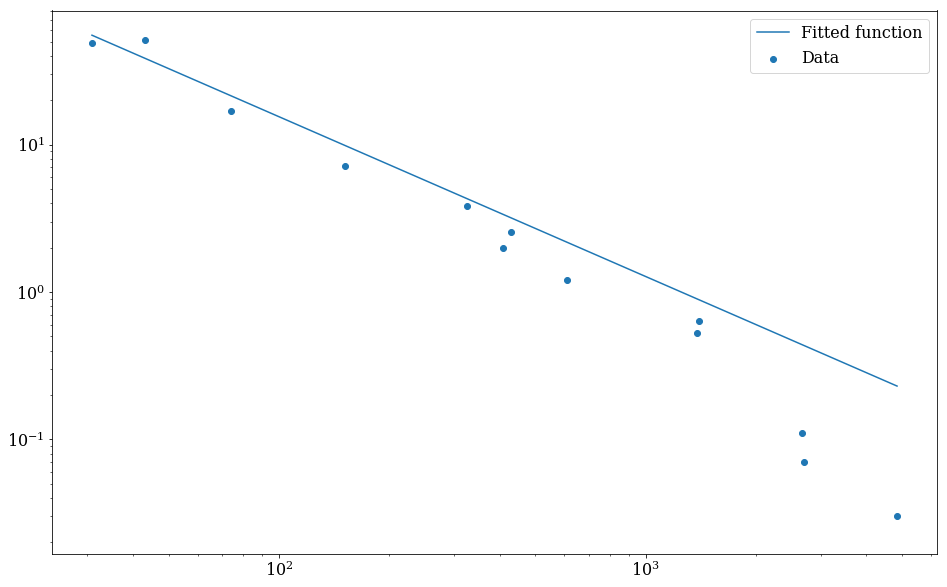

In [170]:
plt.figure(figsize=(15, 10))
plt.scatter(dat_freq, dat_flux, label='Data')
plt.loglog(dat_freq, fitfunc(dat_freq, params[0], params[1]),
         label='Fitted function')

plt.legend(loc='best')

plt.show()

### Fit Sync Fit*
Does not work
- Error about units but why?

In [168]:
from scipy import optimize

#dat_freq2 = dat_freq.to('GHz')



## Sync Spectrum will be identical to the one from "electrons", but with norm as a parameter
## SyncFit , norm set 


def syncfit(x,a):
    return sync_spectrum(x,a)[1]



params, params_covariance = optimize.curve_fit(syncfit, dat_freq2, dat_flux,
                                               p0=[0])

print(params)

UnitConversionError: 'J s' (angular momentum) and 'eV' (energy) are not convertible

## Try with Secondary Electron

In [201]:
from scipy import optimize

#dat_freq2 = dat_freq.to('GHz')



## Sync Spectrum will be identical to the one from "electrons", but with norm as a parameter
## SyncFit , norm set 


def syncfit(x,a):
    return sync_spectrum2(x,a)[1]



params, params_covariance = optimize.curve_fit(syncfit, dat_freq2, dat_flux,
                                               p0=[0])

print(params)

UnitConversionError: 'J s' (angular momentum) and 'eV' (energy) are not convertible